In [ ]:
import sys
import os

# Add the project root to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

import torch
from torch_geometric.data import Data
import networkx as nx
import matplotlib.pyplot as plt
from src.data.return_sub_graph import get_subgraph_first_n_nodes
from torch_geometric.utils import degree

import numpy as np

# Load the data object
data_path = '../data/3_processed/rel-amazon/tasks/user-churn/common_purchased_categories_one_hot_vector/data_thres_0.6.pt'
data = torch.load(data_path, weights_only=False)

# Print basic information
print(data)
print("="*30)
print(f'Number of nodes: {int(data.num_nodes):,}')
print(f'Number of edges: {int(data.num_edges/2):,}')
print(f'Number of node features: {data.num_node_features}')
print(f'Number of edge features: {data.num_edge_features}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
if data.has_isolated_nodes():
    isolated_nodes_count = (degree(data.edge_index[0], num_nodes=data.num_nodes) == 0).sum().item()
    print(f'Number of isolated nodes: {isolated_nodes_count} ~ {isolated_nodes_count/data.num_nodes:.3f}%')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is directed: {data.is_directed()}')

if hasattr(data, 'y') and data.y is not None:
    print(f'Number of classes: {data.y.max().item() + 1}')
    print(f'Class distribution: {torch.bincount(data.y)}')


c:\Users\Luis\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data(x=[5000, 1116], edge_index=[2, 1634562], y=[5000])
Number of nodes: 5,000
Number of edges: 817,281
Number of node features: 1116
Number of edge features: 0
Contains isolated nodes: True
Number of isolated nodes: 198 ~ 0.040%
Contains self-loops: False
Is directed: False
Number of classes: 2
Class distribution: tensor([1888, 3112])


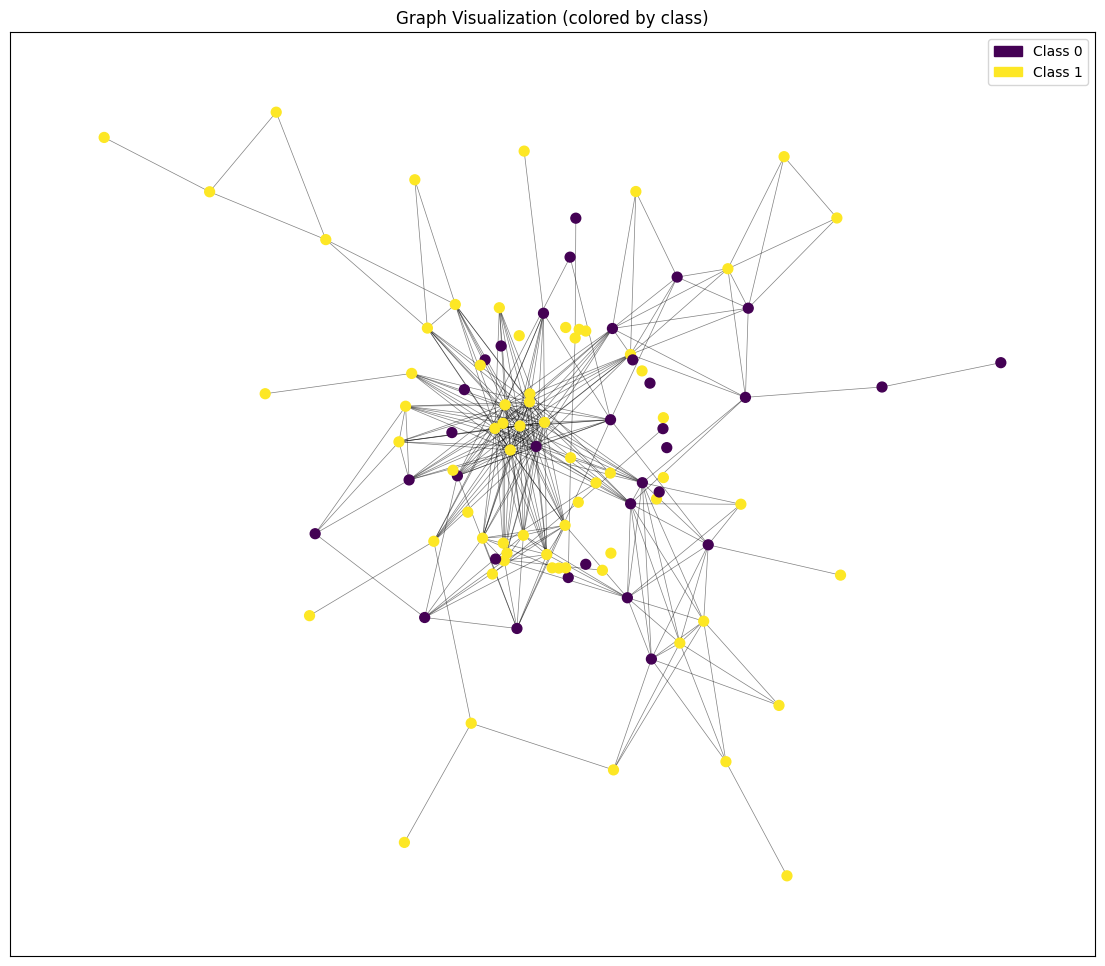

In [4]:
from torch_geometric.utils import to_networkx
import matplotlib.patches as mpatches

# Convert to networkx graph
# We convert to undirected for visualization purposes to get a cleaner layout.
data = get_subgraph_first_n_nodes(torch.load(data_path, weights_only=False), 100)
g = to_networkx(data, to_undirected=True)

# Visualization with node coloring if labels exist
plt.figure(figsize=(14, 12))

title = "Graph Visualization"
pos = nx.kamada_kawai_layout(g)

if hasattr(data, 'y') and data.y is not None:
    node_color = data.y.numpy()
    title = "Graph Visualization (colored by class)"
    
    # Draw nodes
    nx.draw_networkx_nodes(g, pos, node_size=50, cmap=plt.cm.viridis, node_color=node_color)
    nx.draw_networkx_edges(g, pos, width=0.5, alpha=0.5)
    
    # Create legend
    unique_labels = np.unique(node_color)
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_labels)))
    patches = [mpatches.Patch(color=colors[i], label=f'Class {label}') for i, label in enumerate(unique_labels)]
    plt.legend(handles=patches)

else:
    nx.draw(g, pos, with_labels=False, node_size=50, width=0.5)

plt.title(title)
plt.show()


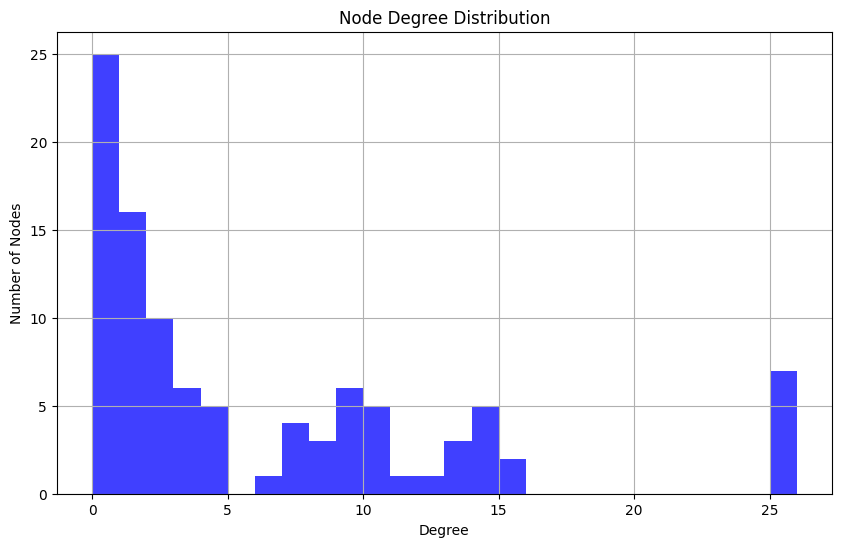

Minimum degree: 0
Maximum degree: 26
Average degree: 5.80


In [ ]:
# Get degrees
degrees = [d for n, d in g.degree()]

# Plotting the degree distribution
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=range(min(degrees), max(degrees) + 1), alpha=0.75, color='b')
plt.title('Node Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.grid(True)
plt.show()

print(f"Minimum degree: {np.min(degrees)}")
print(f"Maximum degree: {np.max(degrees)}")
print(f"Average degree: {np.mean(degrees):.2f}")


Number of connected components: 31
Component sizes: [1, 4, 61, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]


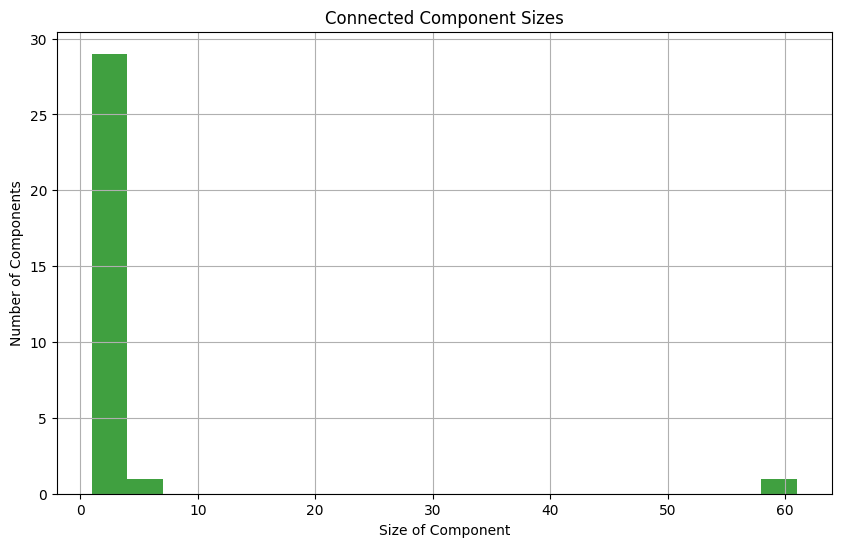

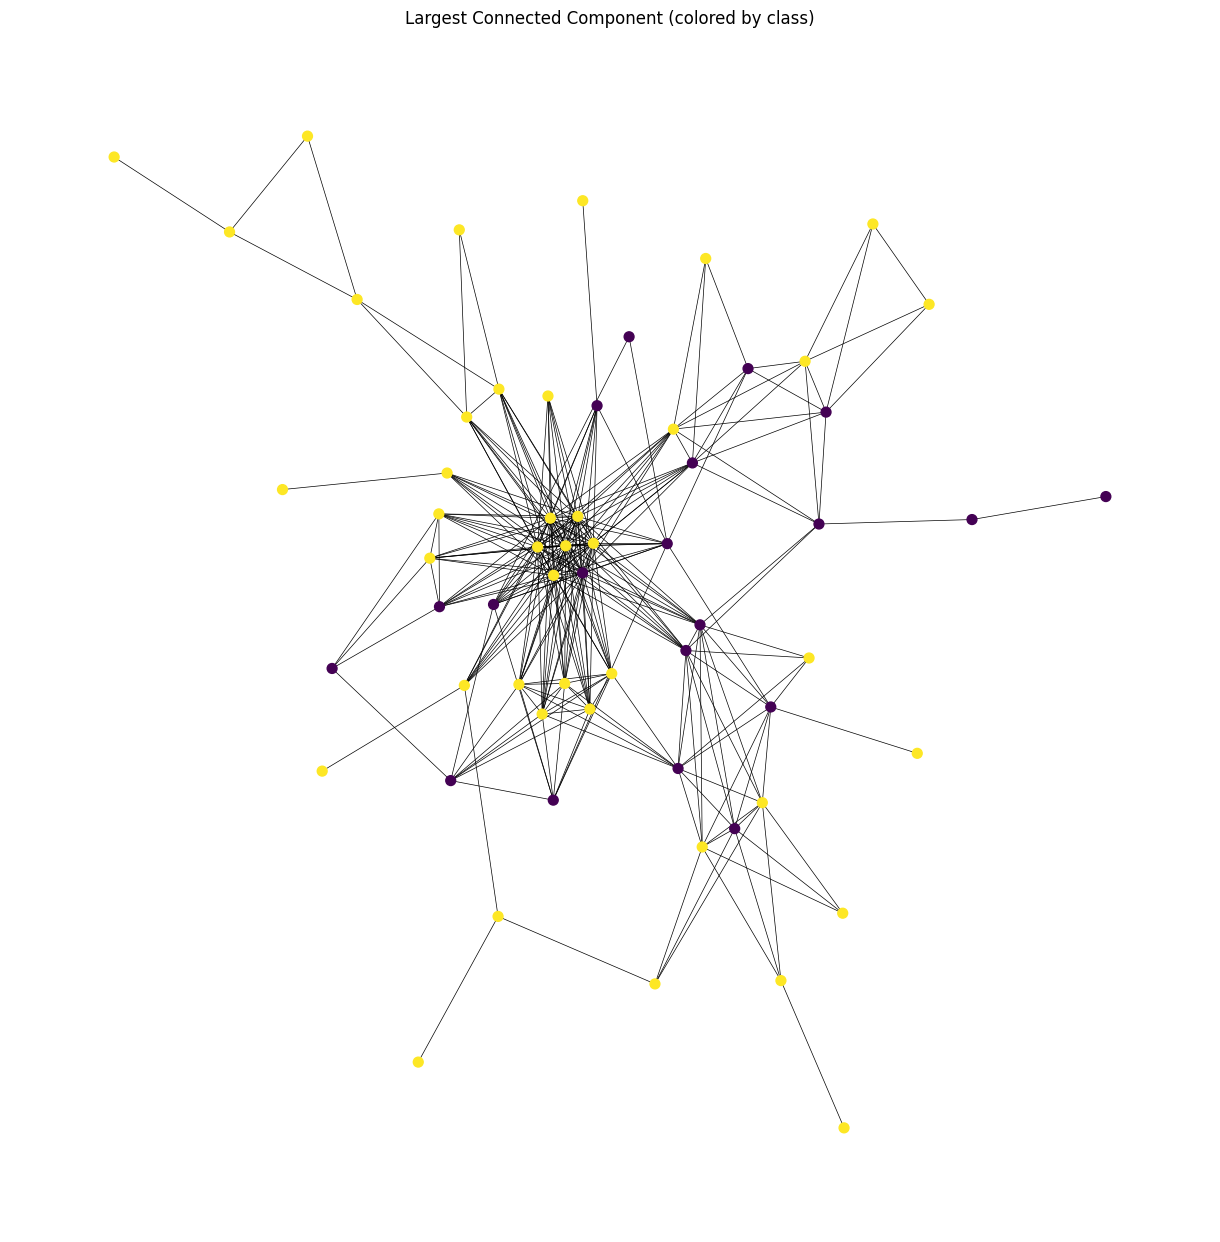

In [22]:
# Get connected components
connected_components = list(nx.connected_components(g))
num_components = len(connected_components)
print(f"Number of connected components: {num_components}")

# Get the size of each component
component_sizes = [len(c) for c in connected_components]
print(f"Component sizes: {component_sizes}")


if num_components > 1:
    # Plotting the component sizes
    plt.figure(figsize=(10, 6))
    plt.hist(component_sizes, bins=20, alpha=0.75, color='g')
    plt.title('Connected Component Sizes')
    plt.xlabel('Size of Component')
    plt.ylabel('Number of Components')
    plt.grid(True)
    plt.show()

    # Visualize the largest component
    largest_component = max(connected_components, key=len)
    g_largest = g.subgraph(largest_component)

    plt.figure(figsize=(12, 12))
    
    node_color = None
    title = "Largest Connected Component"
    if hasattr(data, 'y') and data.y is not None:
        node_indices = list(largest_component)
        node_color = data.y[node_indices].numpy()
        title = "Largest Connected Component (colored by class)"
    
    pos = nx.kamada_kawai_layout(g_largest)
    nx.draw(g_largest, pos, with_labels=False, node_size=50, width=0.5, node_color=node_color, cmap='viridis')
    plt.title(title)
    plt.show()


In [23]:
from sklearn.manifold import TSNE

# Perform t-SNE on node features
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
node_features_2d = tsne.fit_transform(data.x.numpy())

# Create a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(node_features_2d[:, 0], node_features_2d[:, 1], c=data.y.numpy() if hasattr(data, 'y') and data.y is not None else None, cmap='viridis', s=20)
plt.title('t-SNE of Node Features')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')

if hasattr(data, 'y') and data.y is not None:
    plt.legend(*scatter.legend_elements(), title="Classes")

plt.grid(True)
plt.show()


TypeError: TSNE.__init__() got an unexpected keyword argument 'n_iter'

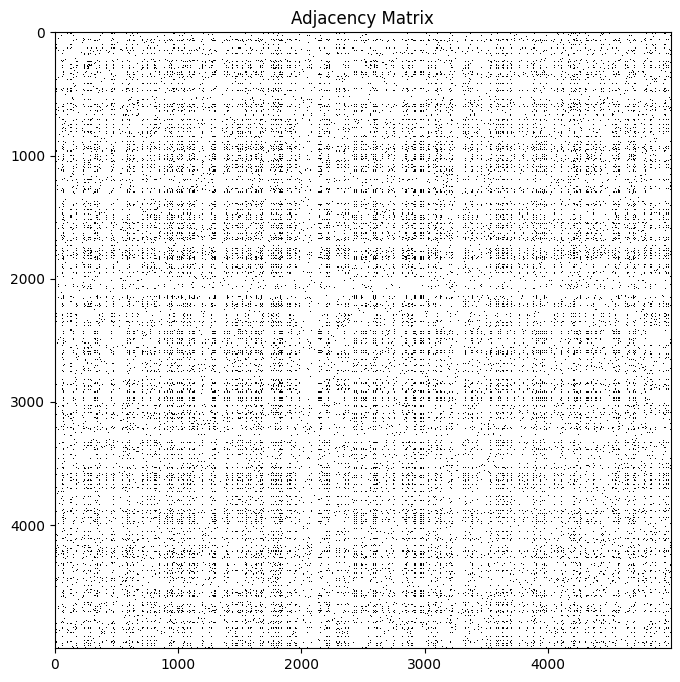

In [24]:
from torch_geometric.utils import to_scipy_sparse_matrix

# Get adjacency matrix
adj_matrix = to_scipy_sparse_matrix(data.edge_index).todense()

# Plot the adjacency matrix
plt.figure(figsize=(8, 8))
plt.imshow(adj_matrix, cmap='Greys', interpolation='none')
plt.title('Adjacency Matrix')
plt.show()
